In [66]:
import xarray as xr
import pygmt
import numpy as np
import geopandas as gpd
import os.path as osp

#https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html
# xarray uses pandas-like structures.
# dataArray is a pandas.Series
# dataset is a dict-like container of data arrays (similar ot a pandas.dataframe)

# Open the NetCDF file
litho_nc_fp = "../../data/LITHO1.0.nc"

dataset = xr.open_dataset(litho_nc_fp)

region1 = [-179.5, 179.5, -89.5, 89.5]

In [67]:
dataset

<xarray.Dataset> Size: 44MB
Dimensions:                            (latitude: 180, longitude: 360)
Coordinates:
  * latitude                           (latitude) float32 720B -89.5 ... 89.5
  * longitude                          (longitude) float32 1kB -179.5 ... 179.5
Data variables: (12/171)
    asthenospheric_mantle_top_depth    (latitude, longitude) float32 259kB ...
    asthenospheric_mantle_top_density  (latitude, longitude) float32 259kB ...
    asthenospheric_mantle_top_vp       (latitude, longitude) float32 259kB ...
    asthenospheric_mantle_top_vs       (latitude, longitude) float32 259kB ...
    asthenospheric_mantle_top_qkappa   (latitude, longitude) float32 259kB ...
    asthenospheric_mantle_top_qmu      (latitude, longitude) float32 259kB ...
    ...                                 ...
    water_top_vs                       (latitude, longitude) float32 259kB ...
    water_top_qkappa                   (latitude, longitude) float32 259kB ...
    water_top_qmu                      (latitude, longitude) float32 259kB ...
    water_top_vp2                      (latitude, longitude) float32 259kB ...
    water_top_vs2                      (latitude, longitude) float32 259kB ...
    water_top_eta                      (latitude, longitude) float32 259kB ...
Attributes: (12/26)
    title:                      An updated crust and lithospheric model of th...
    id:                         LITHO1.0
    summary:                    The is a 1° gridded version of the LITHO1.0 m...
    Conventions:                CF-1.0
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    geospatial_lat_min:         -89.5
    ...                         ...
    author_url:                 https://igppweb.ucsd.edu/~gabi/litho1.0.html
    repository_name:            EMC
    repository_institution:     IRIS DMC
    repository_pid:             doi:10.17611/DP/emc.2020.litho102nc.1
    history:                    2020-09-11 13:44:05 UTC Converted to netCDF b...
    model:                      LITHO1.0

In [68]:
# Access data variables (as numpy)
lon = dataset['longitude'].values
lat = dataset['latitude'].values
lid = dataset['lid_bottom_depth'].values

# Create a meshgrid
lon, lat = np.meshgrid(lon, lat)

# Reshape to 1-D arrays
lid = lid.ravel()
lon = lon.ravel()
lat = lat.ravel()

# Compute block mean
lithomean = pygmt.blockmean(x=lon, y=lat, z=lid, region=region1, spacing=1.0)

In [69]:
# how to convert to geopandas dataframe
lid_gdf = gpd.GeoDataFrame(lithomean[2], geometry=gpd.points_from_xy(lithomean[0], lithomean[1]))
lid_gdf.columns = ['lid_bottom_depth', 'geometry']

lid_gdf

,lid_bottom_depth,geometry
0,95.067001,POINT (-179.5 89.5)
1,94.980003,POINT (-178.5 89.5)
2,94.892998,POINT (-177.5 89.5)
3,94.806000,POINT (-176.5 89.5)
4,94.720001,POINT (-175.5 89.5)
...,...,...
64795,253.244995,POINT (175.5 -89.5)
64796,253.410004,POINT (176.5 -89.5)
64797,253.574005,POINT (177.5 -89.5)
64798,253.738007,POINT (178.5 -89.5)


In [70]:
# create a smooth surface (another option here is to use pygmt.xyz2grd)
lithogrid = pygmt.surface(lithomean, region=region1, spacing=1.0, tension="0.8")

# Check the output grid
print(pygmt.grdinfo(lithogrid))

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Cartesian grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -179.5 x_max: 179.5 x_inc: 1 name: x n_columns: 360
: y_min: -89.5 y_max: 89.5 y_inc: 1 name: y n_rows: 180
: v_min: 8.86699295044 v_max: 320.424987793 name: z
: scale_factor: 1 add_offset: 0
: format: classic
: Default CPT: 



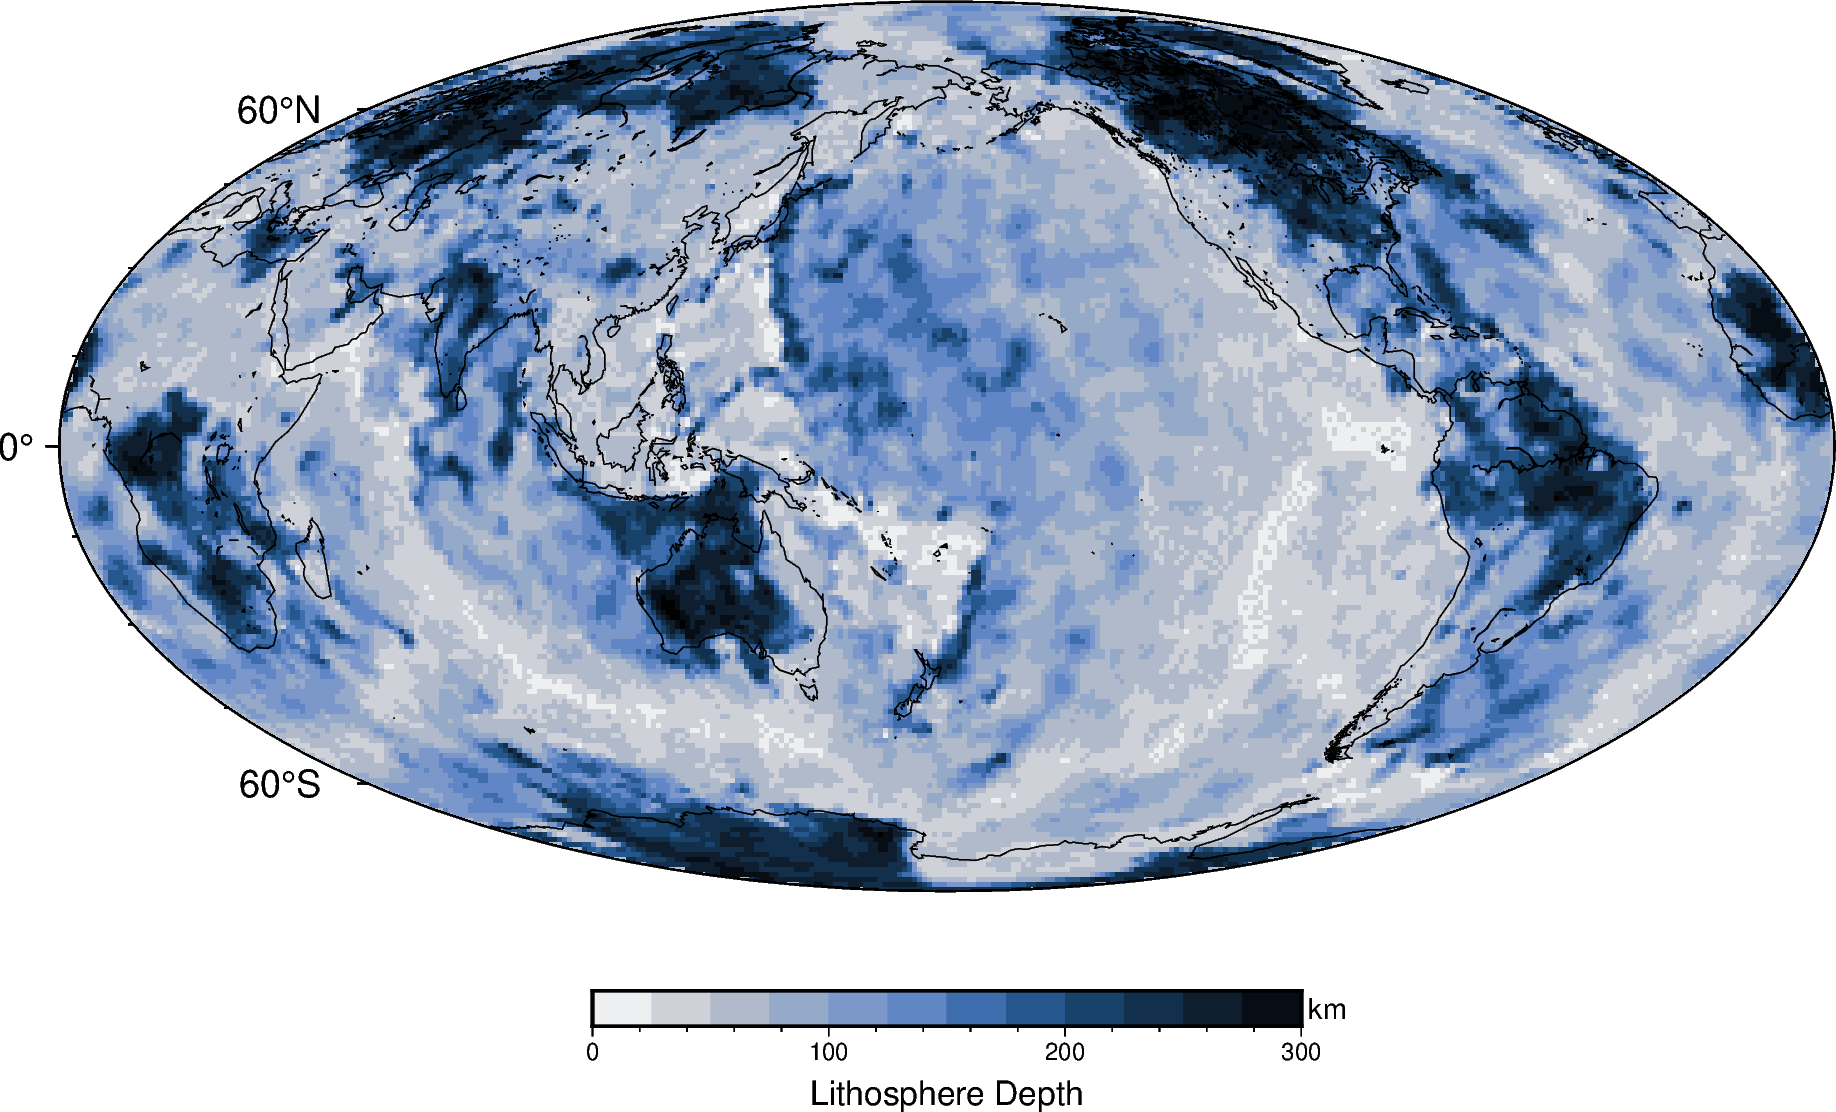

In [71]:
# Create a colormap
cptfile = "lithodepth.cpt"
pygmt.makecpt(cmap="oslo",series=(0,300,25),reverse=True, output=cptfile)

# Start Figure
fig = pygmt.Figure()
fig.basemap(region="g", projection="W15c", frame=True)
fig.grdimage(grid=lithogrid, cmap=cptfile)
fig.colorbar(cmap=cptfile, position="JBC+w6c/0.3c",frame=["x+lLithosphere Depth", "y+lkm"])

# fig.grdcontour(grid=lithogrid, levels=100, annotation=100, pen='0.5p,white')
fig.coast(shorelines=True)

fig.show()

In [72]:
# Can change which layer to choose here
crust = dataset['lower_crust_bottom_depth'].values
nx, ny = crust.shape

# reshape to 1-D arrays
crust = crust.ravel()
lon = lon.ravel()
lat = lat.ravel()

# Compute block mean for crust data
crustmean = pygmt.blockmean(x=lon, y=lat, z=crust, region=region1, spacing=1.0)

# Create a smooth surface for crust data
crustgrid = pygmt.surface(crustmean, region=region1, spacing=1.0, tension="0.8")

# Create a colormap for crust data
cptfile1 = "crustdepth.cpt"
pygmt.makecpt(cmap="bilbao", series=(0, 60, 5), reverse=True, output=cptfile1)

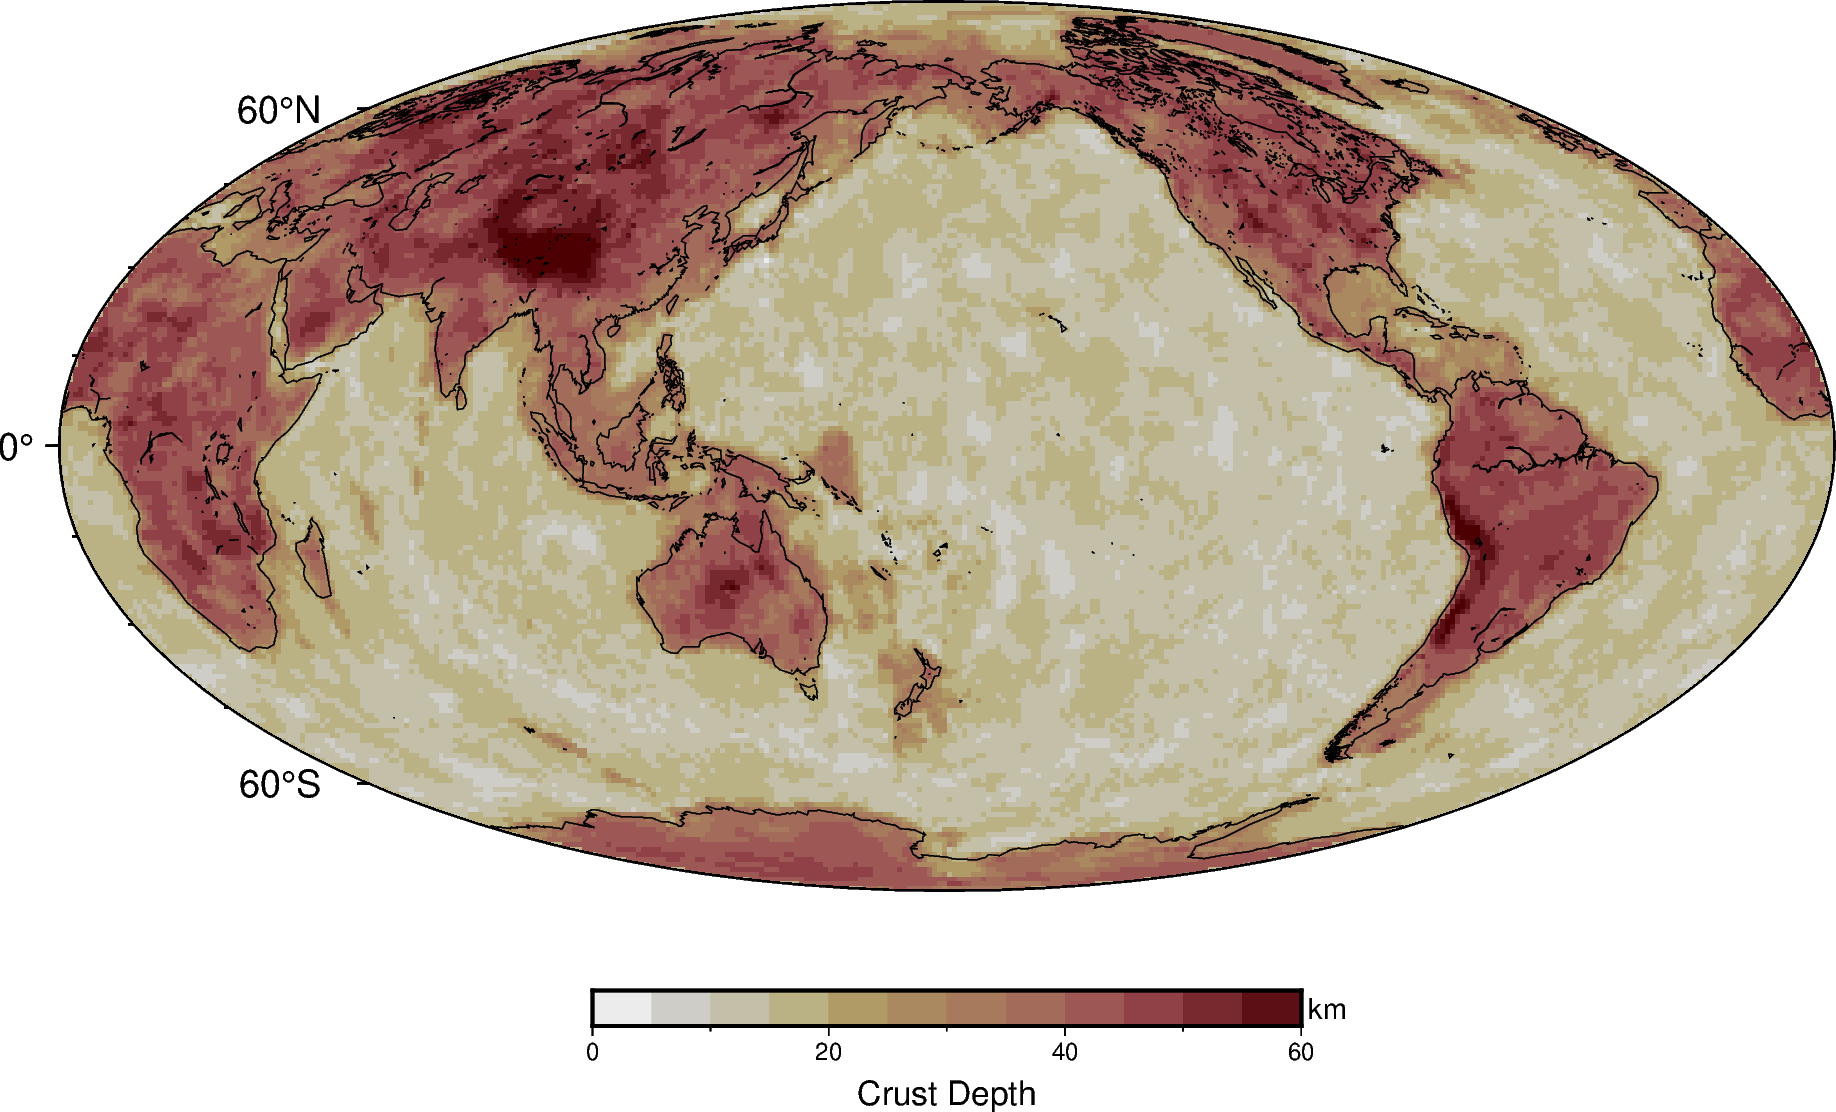

In [73]:
# Start a new figure for crust data
fig = pygmt.Figure()
fig.basemap(region="g", projection="W15c", frame=True)
fig.grdimage(grid=crustgrid, cmap=cptfile1)
fig.colorbar(cmap=cptfile1, position="JBC+w6c/0.3c", frame=["x+lCrust Depth", "y+lkm"])
fig.coast(shorelines=True)

fig.show()